In [361]:
import os
from glob import glob
import numpy as np
import pandas
from nilearn import image, input_data
import nibabel as ni
import scipy.stats as stats
from scipy.io import savemat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_extraction.image import grid_to_graph
import statsmodels.distributions.empirical_distribution as ed
from sklearn.mixture import GaussianMixture

In [2]:
wdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images'
ans = sorted(glob(os.path.join(wdir,'amyloid_negative/smoothed/*')))
aps = sorted(glob(os.path.join(wdir,'amyloid_positive/smoothed/*')))
s_scans = ans+aps
ica_scans = sorted(glob(os.path.join(wdir,'smoothed_ICA_regressed_scans/*')))
wtd_scans = sorted(glob(os.path.join(wdir,'smoothed_weighted_by_amyloid_T_test_scans/*')))
wi_scans = sorted(glob(os.path.join(wdir,'smoothed_weighted_and_ICA_regress_images/*')))
dkt = '/data1/users/jvogel/ADNI_tau/dkt_atlas_1p5mm.nii'

In [352]:
ica_scans2 = sorted(glob(os.path.join(wdir,'smoothed_ICA_regressed_scans_2/*')))

In [297]:
files_in = s_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/'
out_name = 'smoothed_vx_ref'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


In [298]:
pdf = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/smoothed_vx_ref_roi_data.csv')
pdf.drop(pdf.columns[78:],axis=1,inplace=True)
pdf.head()

,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_69,roi_70,roi_71,roi_72,roi_73,roi_74,roi_75,roi_76,roi_77,roi_78
0,0.701645,0.676591,0.461776,0.527256,0.372574,0.447080,0.443195,0.408220,0.321967,0.628237,...,0.779303,0.569502,0.176098,0.706148,0.457584,0.541927,0.424773,0.524714,0.518405,0.616898
1,0.564308,0.368153,0.656585,0.700573,0.654706,0.371894,0.467564,0.825658,0.383969,0.610331,...,0.181682,0.662550,0.686077,0.496544,0.859984,0.496997,0.709937,0.673838,0.743749,0.719969
2,0.789790,0.348759,0.730640,0.247916,0.467068,0.314607,0.257625,0.584427,0.629005,0.484974,...,0.741756,0.577083,0.915049,0.426398,0.457865,0.892730,0.382639,0.898133,0.846154,0.700073
3,0.529252,0.641854,0.545657,0.226188,0.319547,0.379725,0.347738,0.465418,0.398971,0.391503,...,0.850852,0.514655,0.728162,0.440800,0.469000,0.765215,0.547062,0.757598,0.712874,0.642555
4,0.443489,0.390835,0.487892,0.535985,0.256538,0.561640,0.295780,0.377131,0.640701,0.484316,...,0.572651,0.349538,0.230229,0.403451,0.376962,0.425333,0.338289,0.388638,0.370255,0.377717


In [299]:
sorter = pandas.DataFrame(pdf,copy=True)
sorter.loc[:,'mean'] = pdf.mean(axis=1)
sorter.sort_values('mean',axis=0)

,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_70,roi_71,roi_72,roi_73,roi_74,roi_75,roi_76,roi_77,roi_78,mean
9,0.132404,0.171149,0.114690,0.224614,0.447901,0.103948,0.414700,0.100809,0.116046,0.230612,...,0.045875,0.018446,0.038327,0.077455,0.010475,0.054840,0.017661,0.023903,0.058370,0.183000
236,0.129481,0.258136,0.237620,0.145569,0.209490,0.303710,0.281887,0.057777,0.248788,0.159982,...,0.100279,0.121014,0.129482,0.078016,0.139468,0.059723,0.097983,0.127049,0.196631,0.200961
210,0.205373,0.134410,0.286175,0.230547,0.225575,0.238801,0.245714,0.175562,0.314147,0.198432,...,0.081760,0.144234,0.386869,0.090204,0.412589,0.187295,0.188416,0.187576,0.171665,0.210975
189,0.184854,0.301066,0.186653,0.130300,0.565764,0.156553,0.533452,0.172779,0.235220,0.224418,...,0.113230,0.273366,0.160444,0.546655,0.072980,0.198752,0.126918,0.117671,0.173506,0.225317
230,0.071432,0.404990,0.263651,0.251229,0.200064,0.345578,0.463422,0.111380,0.405216,0.193216,...,0.039299,0.091837,0.162459,0.087458,0.122015,0.239789,0.034116,0.054171,0.329328,0.253536
156,0.100868,0.205454,0.105548,0.297368,0.322857,0.264741,0.340000,0.189891,0.255769,0.287966,...,0.152617,0.314400,0.082196,0.384349,0.282575,0.527943,0.067478,0.057679,0.261926,0.255091
174,0.323483,0.354917,0.278982,0.215381,0.452670,0.339024,0.236268,0.098694,0.273998,0.287358,...,0.116333,0.309346,0.096926,0.183645,0.087579,0.059422,0.096592,0.074728,0.145029,0.259990
114,0.353730,0.429905,0.401327,0.312810,0.081337,0.531545,0.267957,0.347429,0.551637,0.255499,...,0.108326,0.056752,0.068361,0.074398,0.118298,0.087250,0.068499,0.060695,0.136657,0.263684
122,0.260832,0.341196,0.073986,0.476698,0.440705,0.168482,0.298523,0.369569,0.074369,0.433424,...,0.099651,0.365901,0.054783,0.288863,0.256944,0.081105,0.247955,0.225719,0.239526,0.271457
5,0.101960,0.244766,0.211806,0.340422,0.327496,0.390493,0.564167,0.117820,0.417550,0.129223,...,0.491007,0.347225,0.122232,0.201566,0.472543,0.346735,0.295267,0.296148,0.251296,0.275200


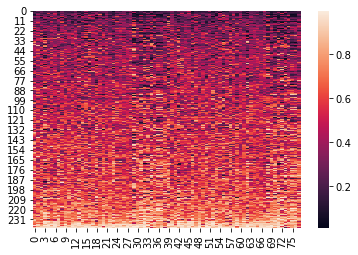

In [307]:
plt.close()
sns.heatmap(pdf.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [316]:
files_in = ica_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/'
out_name = 'smoothed_vx_ref_ica_regr'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


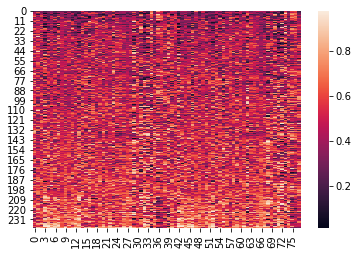

In [317]:
pdf_ica = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/smoothed_vx_ref_ica_regr_roi_data.csv')
pdf_ica.drop(pdf_ica.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(pdf_ica,copy=True)
sorter.loc[:,'mean'] = pdf_ica.mean(axis=1)
plt.close()
sns.heatmap(pdf_ica.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [318]:
files_in = wtd_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/'
out_name = 'smoothed_vx_ref_am_t_wtd'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


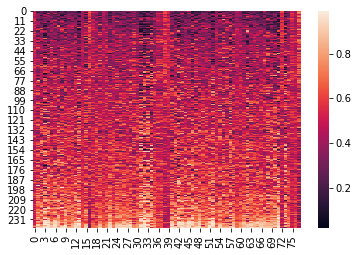

In [319]:
pdf_wtd = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/smoothed_vx_ref_am_t_wtd_roi_data.csv')
pdf_wtd.drop(pdf_wtd.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(pdf_wtd,copy=True)
sorter.loc[:,'mean'] = pdf_wtd.mean(axis=1)
plt.close()
sns.heatmap(pdf_wtd.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [320]:
files_in = wi_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/'
out_name = 'smoothed_vx_ref_wtd_and_ICA'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


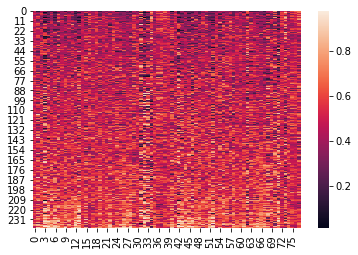

In [321]:
pdf_wi = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/smoothed_vx_ref_wtd_and_ICA_roi_data.csv')
pdf_wi.drop(pdf_wi.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(pdf_wi,copy=True)
sorter.loc[:,'mean'] = pdf_wi.mean(axis=1)
plt.close()
sns.heatmap(pdf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

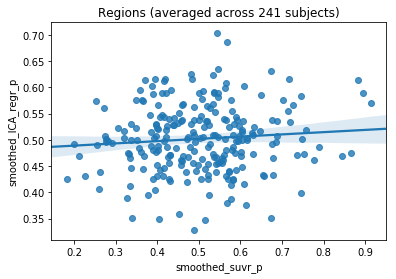

0.00780811241562


In [324]:
plt.close()
sns.regplot(pdf.mean(axis=1),pdf_ica.mean(axis=1))
plt.xlabel('smoothed_suvr_p')
plt.ylabel('smoothed_ICA_regr_p')
plt.title('Regions (averaged across 241 subjects)')
plt.show()
print(stats.pearsonr(pdf.mean(axis=1),pdf_ica.mean(axis=1))[0]**2)

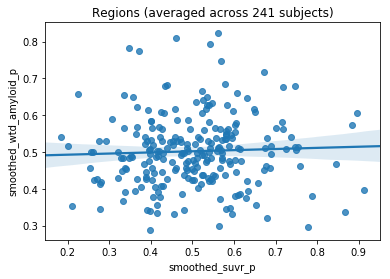

0.00180952590329


In [325]:
plt.close()
sns.regplot(pdf.mean(axis=1),pdf_wtd.mean(axis=1))
plt.xlabel('smoothed_suvr_p')
plt.ylabel('smoothed_wtd_amyloid_p')
plt.title('Regions (averaged across 241 subjects)')
plt.show()
print(stats.pearsonr(pdf.mean(axis=1),pdf_wtd.mean(axis=1))[0]**2)

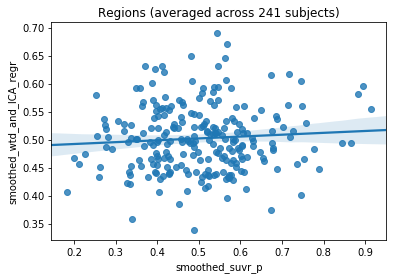

0.00563950151614


In [326]:
plt.close()
sns.regplot(pdf.mean(axis=1),pdf_wi.mean(axis=1))
plt.xlabel('smoothed_suvr_p')
plt.ylabel('smoothed_wtd_and_ICA_regr')
plt.title('Regions (averaged across 241 subjects)')
plt.show()
print(stats.pearsonr(pdf.mean(axis=1),pdf_wi.mean(axis=1))[0]**2)

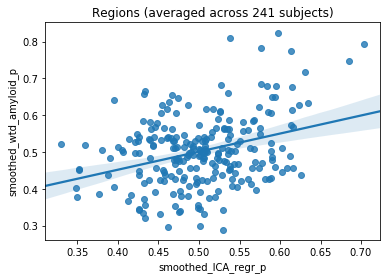

0.107124657319


In [327]:
plt.close()
sns.regplot(pdf_ica.mean(axis=1),pdf_wtd.mean(axis=1))
plt.xlabel('smoothed_ICA_regr_p')
plt.ylabel('smoothed_wtd_amyloid_p')
plt.title('Regions (averaged across 241 subjects)')
plt.show()
print(stats.pearsonr(pdf_ica.mean(axis=1),pdf_wtd.mean(axis=1))[0]**2)

In [86]:
tdf = pandas.read_csv('/data1/users/jvogel/ADNI_tau/big_tau.csv',index_col = 0)
idf = pandas.read_csv('/data1/users/jvogel/ADNI_tau/template_space/tau_images/ica_values_basic_IC20_smoothed.csv')

In [90]:
tdf.columns

Index(['ID', 'visit', 'scandate', '1_OffTarget', '2_Frontal', '3_Temporal',
       '4_Temporoparietal', '5_Sensory', 'Hipp_OffTarget', 'Hipp_EarlyTau',
       'AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'AV45', 'CDRSB', 'ADAS11',
       'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning',
       'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'MOCA',
       'EcogSPTotal', 'EcogPtTotal', 'ICV', 'DX_fill', 'av45_status',
       'reference_date', 'time_difference_days', 'whole_hippocampus_AV1451',
       'av45_date', 'av45_time_difference_days', 'ADNI_MEM', 'ADNI_EF'],
      dtype='object')

In [91]:
idf.columns

Index(['subject', 'visit', 'ica_0', 'ica_1', 'ica_2', 'ica_3', 'ica_4',
       'ica_5', 'ica_6', 'ica_7', 'ica_8', 'ica_9', 'ica_10', 'ica_11',
       'ica_12', 'ica_13', 'ica_14', 'ica_15', 'ica_16', 'ica_17', 'ica_18',
       'ica_19', 'amyloid_status'],
      dtype='object')

In [328]:
for i,row in idf.iterrows():
    dx = tdf[(tdf.ID == row['subject']) & (tdf.visit == row['visit'])]['DX_fill'].values
    if len(dx) > 0:
        idf.loc[i,'DX'] = dx[0]

In [329]:
neg_index = idf[(idf.amyloid_status==0) & (idf.DX == 'NL')].index.tolist()

In [330]:
files_in = s_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/'
out_name = 'smoothed_vx_anmeg_NL_ref'
ref_index = neg_index
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, ref_index=ref_index)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


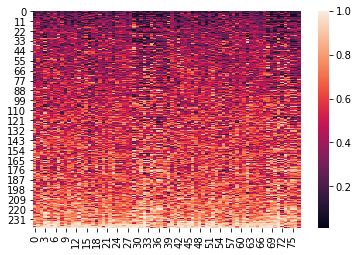

In [331]:
rpdf = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/smoothed_vx_anmeg_NL_ref_roi_data.csv')
rpdf.drop(rpdf.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(rpdf,copy=True)
sorter.loc[:,'mean'] = rpdf.mean(axis=1)
plt.close()
sns.heatmap(rpdf.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [332]:
files_in = ica_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/'
out_name = 'smoothed_ICA_regr_vx_anmeg_NL_ref'
ref_index = neg_index
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, ref_index=ref_index)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


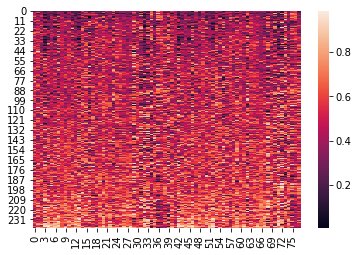

In [333]:
rpdf_ica = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/smoothed_ICA_regr_vx_anmeg_NL_ref_roi_data.csv')
rpdf_ica.drop(rpdf_ica.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(rpdf_ica,copy=True)
sorter.loc[:,'mean'] = rpdf_ica.mean(axis=1)
plt.close()
sns.heatmap(rpdf_ica.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [334]:
files_in = wtd_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/'
out_name = 'smoothed_wtd_am_anmeg_NL_ref'
ref_index = neg_index
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, ref_index=ref_index)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


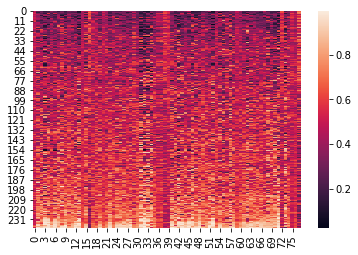

In [340]:
rpdf_wtd = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/smoothed_wtd_am_anmeg_NL_ref_roi_data.csv')
rpdf_wtd.drop(rpdf_wtd.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(rpdf_wtd,copy=True)
sorter.loc[:,'mean'] = rpdf_wtd.mean(axis=1)
plt.close()
sns.heatmap(rpdf_wtd.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [341]:
files_in = wi_scans
atlas = dkt
ref = 'voxelwise'
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/'
out_name = 'smoothed_ICA_wtd_am_anmeg_NL_ref'
ref_index = neg_index
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, ref_index=ref_index)

initiating...
loading data...
processing 241 subjects
masking data...
generating voxelwise ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


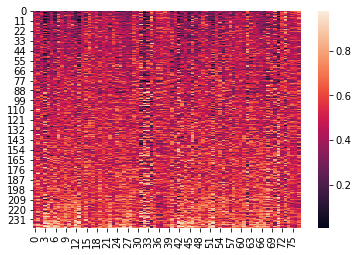

In [342]:
rpdf_wi = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/smoothed_ICA_wtd_am_anmeg_NL_ref_roi_data.csv')
rpdf_wi.drop(rpdf_wi.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(rpdf_wi,copy=True)
sorter.loc[:,'mean'] = rpdf_wi.mean(axis=1)
plt.close()
sns.heatmap(rpdf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

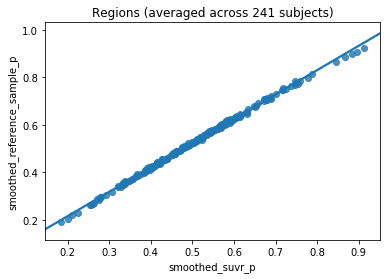

0.998434854982


In [344]:
plt.close()
sns.regplot(pdf.mean(axis=1),rpdf.mean(axis=1))
plt.xlabel('smoothed_suvr_p')
plt.ylabel('smoothed_reference_sample_p')
plt.title('Regions (averaged across 241 subjects)')
plt.show()
print(stats.pearsonr(pdf.mean(axis=1),rpdf.mean(axis=1))[0]**2)

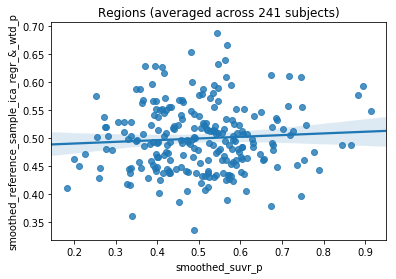

0.00456383594133


In [346]:
plt.close()
sns.regplot(pdf.mean(axis=1),rpdf_wi.mean(axis=1))
plt.xlabel('smoothed_suvr_p')
plt.ylabel('smoothed_reference_sample_ica_regr_&_wtd_p')
plt.title('Regions (averaged across 241 subjects)')
plt.show()
print(stats.pearsonr(pdf.mean(axis=1),rpdf_wi.mean(axis=1))[0]**2)

In [360]:
dfs = {'suvr': pdf,'ica': pdf_ica, 'weighted': pdf_wtd, 'ICA+weighted': pdf_wi,
      'suvr+refsample': rpdf, 'ica+refsample': rpdf_ica, 'weight+refsample': rpdf_wtd, 'ICA+weighted+refsample':rpdf_wi}

for k,df in dfs.items():
    df.loc[:,'amyloid'] = idf.amyloid_status.values
    df.loc[:,'DX'] = idf.DX.values
    print('for',k)
    thits = []
    fhits = []
    for i,col in enumerate(df.columns[:78]):
        t,p = stats.ttest_ind(df[df.amyloid==0][col],
                            df[df.amyloid==1][col])
        if p < 0.05:
            thits.append(i)
        f,p2 = stats.f_oneway(df[df.DX=='NL'][col],
                              df[df.DX=='MCI'][col],
                              df[df.DX=='Dementia'][col])
        if p < 0.05:
            fhits.append(i)
    print('%s regions were different by amyloid group'%len(thits))
    print(thits)
    print('%s regions were different by disease group'%len(fhits))
    print(fhits)

for suvr
39 regions were different by amyloid group
[1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 19, 22, 24, 25, 26, 27, 28, 32, 35, 40, 42, 43, 44, 45, 46, 47, 48, 51, 52, 58, 61, 63, 64, 65, 67, 71, 74, 77]
39 regions were different by disease group
[1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 19, 22, 24, 25, 26, 27, 28, 32, 35, 40, 42, 43, 44, 45, 46, 47, 48, 51, 52, 58, 61, 63, 64, 65, 67, 71, 74, 77]
for ica
10 regions were different by amyloid group
[3, 21, 30, 32, 34, 38, 47, 49, 53, 77]
10 regions were different by disease group
[3, 21, 30, 32, 34, 38, 47, 49, 53, 77]
for weighted
13 regions were different by amyloid group
[3, 5, 6, 10, 29, 36, 37, 38, 45, 49, 55, 56, 77]
13 regions were different by disease group
[3, 5, 6, 10, 29, 36, 37, 38, 45, 49, 55, 56, 77]
for ICA+weighted
12 regions were different by amyloid group
[3, 29, 30, 32, 34, 36, 37, 38, 45, 47, 49, 77]
12 regions were different by disease group
[3, 29, 30, 32, 34, 36, 37, 38, 45, 47, 49, 77]
for suvr+refsample
32 regions wer

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


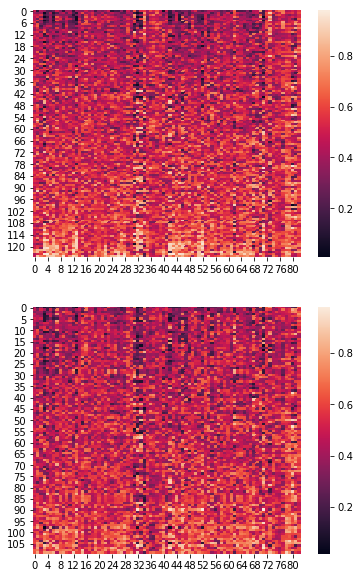

In [349]:
rpdf_wi = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/smoothed_ICA_wtd_am_anmeg_NL_ref_roi_data.csv')
sorter = pandas.DataFrame(rpdf_wi,copy=True)
sorter.loc[:,'mean'] = rpdf_wi.mean(axis=1)
plt.close()
fig,(ax1,ax2) = plt.subplots(2,figsize=(6,10))
sns.heatmap(rpdf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index][rpdf.amyloid==0].values,ax=ax1)
sns.heatmap(rpdf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index][rpdf.amyloid==1].values,ax=ax2)
plt.show()

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


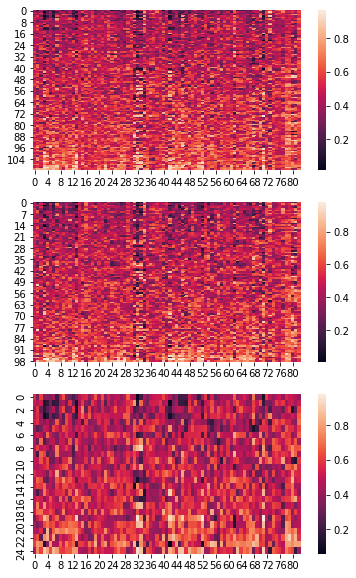

In [350]:
rpdf_wi = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_am_neg_NL_ref/smoothed_ICA_wtd_am_anmeg_NL_ref_roi_data.csv')
sorter = pandas.DataFrame(rpdf_wi,copy=True)
sorter.loc[:,'mean'] = rpdf_wi.mean(axis=1)
plt.close()
fig,(ax1,ax2,ax3) = plt.subplots(3,figsize=(6,10))
sns.heatmap(rpdf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index][rpdf.DX=='NL'].values,ax=ax1)
sns.heatmap(rpdf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index][rpdf.DX=='MCI'].values,ax=ax2)
sns.heatmap(rpdf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index][rpdf.DX=='Dementia'].values,ax=ax3)
plt.show()

In [202]:
files_in = s_scans
atlas = dkt
ref = None
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/'
out_name = 'smoothed_SUVR'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
skipping ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


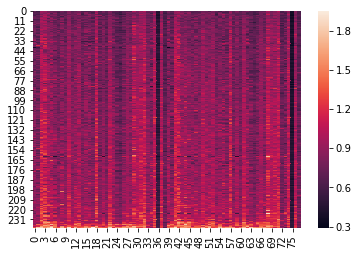

In [235]:
ndf = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/smoothed_SUVR_roi_data.csv')
ndf.drop(ndf.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(ndf,copy=True)
sorter.loc[:,'mean'] = ndf.mean(axis=1)
plt.close()
sns.heatmap(ndf.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [236]:
files_in = ica_scans
atlas = dkt
ref = None
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/'
out_name = 'smoothed_ICA_regr'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
skipping ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


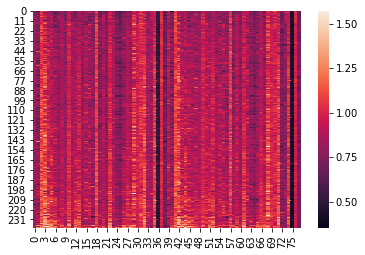

In [238]:
ndf_ica = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/smoothed_ICA_regr_roi_data.csv')
ndf_ica.drop(ndf_ica.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(ndf_ica,copy=True)
sorter.loc[:,'mean'] = ndf_ica.mean(axis=1)
plt.close()
sns.heatmap(ndf_ica.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [354]:
files_in = ica_scans2
atlas = dkt
ref = None
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/'
out_name = 'smoothed_ICA_regr_2'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
skipping ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


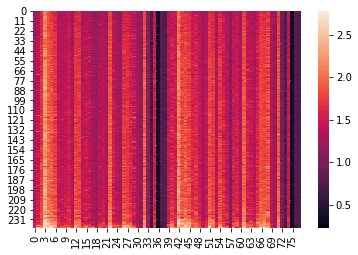

In [355]:
ndf_ica2 = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/smoothed_ICA_regr_2_roi_data.csv')
ndf_ica2.drop(ndf_ica2.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(ndf_ica2,copy=True)
sorter.loc[:,'mean'] = ndf_ica2.mean(axis=1)
plt.close()
sns.heatmap(ndf_ica2.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [239]:
files_in = wtd_scans
atlas = dkt
ref = None
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/'
out_name = 'smoothed_wtd_amyloid'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
skipping ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


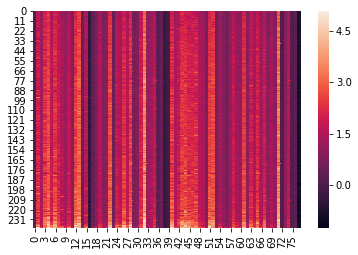

In [242]:
ndf_wtd = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/smoothed_wtd_amyloid_roi_data.csv')
ndf_wtd.drop(ndf_wtd.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(ndf_wtd,copy=True)
sorter.loc[:,'mean'] = ndf_wtd.mean(axis=1)
plt.close()
sns.heatmap(ndf_wtd.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

In [243]:
files_in = wi_scans
atlas = dkt
ref = None
outdir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/'
out_name = 'smoothed_wtd_and_ICA_regr'
prepare_PET_data(files_in, atlas = dkt, ref = ref, out_dir = outdir, out_name = out_name, save_images = True)

initiating...
loading data...
processing 241 subjects
masking data...
skipping ECDF...
transforming back into image space
generating final subject x region matrix
preparing outputs


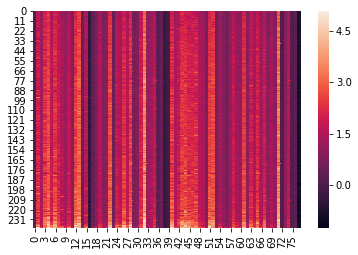

In [244]:
ndf_wi = pandas.read_csv(
    '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/smoothed_wtd_amyloid_roi_data.csv')
ndf_wi.drop(ndf_wi.columns[78:],axis=1,inplace=True)
sorter = pandas.DataFrame(ndf_wtd,copy=True)
sorter.loc[:,'mean'] = ndf_wi.mean(axis=1)
plt.close()
sns.heatmap(ndf_wi.loc[sorter.sort_values('mean',axis=0,ascending=True).index].values)
plt.show()

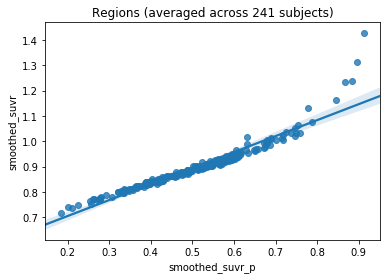

0.902874208062


In [305]:
plt.close()
sns.regplot(pdf[pdf.columns[:78]].mean(axis=1),ndf.mean(axis=1))
plt.xlabel('smoothed_suvr_p')
plt.ylabel('smoothed_suvr')
plt.title('Regions (averaged across 241 subjects)')
plt.show()
print(stats.pearsonr(pdf[pdf.columns[:78]].mean(axis=1),ndf.mean(axis=1))[0]**2)

In [357]:
ndfs = {'suvr': ndf,'ica': ndf_ica, 'ica_2': ndf_ica2, 'weighted': ndf_wtd, 'ICA+weighted': ndf_wi}

for k,df in ndfs.items():
    df.loc[:,'amyloid'] = idf.amyloid_status.values
    df.loc[:,'DX'] = idf.DX.values
    print('for',k)
    thits = []
    fhits = []
    for i,col in enumerate(df.columns[:78]):
        t,p = stats.ttest_ind(df[df.amyloid==0][col],
                            df[df.amyloid==1][col])
        if p < 0.05:
            thits.append([i,t])
        f,p2 = stats.f_oneway(df[df.DX=='NL'][col],
                              df[df.DX=='MCI'][col],
                              df[df.DX=='Dementia'][col])
        if p < 0.05:
            fhits.append(i)
    print('%s regions were different by amyloid group'%len(thits))
    print(thits)
    print('%s regions were different by disease group'%len(fhits))
    print(fhits)

for suvr
47 regions were different by amyloid group
[[1, -3.6197348294263061], [3, -2.7494687372788817], [4, -4.0304555049318065], [5, -2.6992123695130932], [6, -4.1373462942594523], [7, -3.2093748128016717], [8, -2.4961806459376632], [9, -2.2343212315142007], [10, -2.4323368367394691], [12, -4.3142819225723255], [13, -4.0459810437969299], [15, -2.7870116187806362], [19, -3.0395373880954542], [21, -2.1438744048500444], [22, -3.8642560250758828], [24, -3.3307768338407198], [25, -3.156921213206942], [26, -4.2972885238913863], [27, -2.7742931070865078], [28, -4.7067166447131932], [31, -2.2467780507793873], [32, -4.0448353624682918], [35, -2.2539773896047586], [40, -4.2579155830925979], [41, -2.0171133988081222], [42, -2.3296302117797438], [43, -3.9836710279445775], [44, -3.8127027021989748], [45, -3.9352860101860827], [46, -3.1397820725806311], [47, -3.9878965712460066], [48, -2.6745609696354995], [49, -2.2765759717560501], [51, -4.2041307435468047], [52, -3.8713960490406643], [54, -2.131

In [296]:
def prepare_PET_data(files_in, atlas, ref = None, msk = None, dimension_reduction = False,
                     ECDF_in = None, output_type = 'py', out_dir = './', out_name = 'PET_data', 
                     save_matrix = False, save_ECDF = False, save_images = False, ref_index = []):
    ''' This is a function that will take several PET images and an atlas and will
    return a subject X region matrix. If specified, the function will also calculate 
    probabilities (via ECDF) either voxelwise, or using a specified reference region
    
    files_in = input can either be 
        - a path to a directory full of (only) nifti images OR
        - a "search string" using wildcards
        - a list of subject paths OR
        - a subject X image matrix
        
    altas = a path to a labeled regional atlas in the same space as the PET data
    
    ref = multiple options:
        - If None, no probabilities will be calculated, and script will simply extract
        regional PET data using the atlas.
        - If a path to a reference region mask, will calculate voxelwise probabilities
        based on values within the reference region. Mask must be in the same space as 
        as PET data and atlas
        - If a list of integers, will combine these atlas labels with these integers to 
        make reference region 
        - if 'voxelwise', voxelwise (or atom-wise from dimension reduction) probabilities
        will be estimated. In other words, each voxel or atom will use serve as its own
        reference.
        
    msk = A path to a binary mask file in the same space as PET data and atlas. If None,
        mask will be computed as a binary mask of the atlas.
        ** PLEASE NOTE: The mask will be used to mask the reference region! **
    
    dimension_reduction = whether or not to first reduce dimensions of data using
    hierarchical clustering. This results in an initial step that will be very slow, but 
    will may result in an overall speedup for the script, but perhaps only if ref is set 
    to 'voxelwise'.
        - If None, do not perform dimension reduction
        - If integer, the number of atoms (clusters) to reduce to
    
    ECDF_in = If the user wishes to apply an existing ECDF to the PET data instead of
        generating one de novo, that can be done here. This crucial if the user wishes to
        use multiple datasets. Think of it like scaling in machine learning.
        - If None, will generate ECDF de novo.
        - If np.array, will use this array to generate the ECDF.
        - If statsmodel ECDF object, will use this as ECDF
        - If a path, will use the
    
    output_type = type of file to save final subject x region matrix into. multiple options:
        -- 'py' will save matrix into a csv
        -- 'mat' will save matrix into a matfile
    
    out_dir = location to save output files. Defaults to current directory
    
    out_name = the prefix for all output files
    
    save_matrix = Whether to save or return subject x image matrix. Useful if running multiple 
        times, as this matrix can be set as files_in, bypassing the costly data import
        -- if 'return', will return subject x image matrix to python environment
        -- if 'save', will write subject x image matrix to file. 
        -- if None, matrix will not be stored
    
    save_ECDF = whether to save the ECDF used to create the probabilities. This is crucial if 
        using multiple datasets. The resulting output can be used as input for the ECDF argument.
        -- if 'return, will return np.array to python environment
        -- if 'save', will write array to file
        -- if None, array will not be stored
    
    '''
    # Check input arguments
    print('initiating...')
    if output_type != 'py' and output_type != 'mat':
        raise IOError('output_type must be set to py or mat')
    
    
    # Initialize variables
    
    # Load data
    print('loading data...')
    i4d = load_data(files_in) # load PET data
    if save_matrix == 'save':
        otpt = os.path.join(out_dir,'%s_4d_data'%out_name)
        print('saving 4d subject x scan to nifti image: \n',otpt)
        i4d.to_filename(otpt)
    
    # load atlas
    atlas = ni.load(atlas).get_data().astype(int) 
    if atlas.shape != i4d.shape[:3]:
        raise ValueError('atlas dimensions do not match PET data dimensions')
    
    # load reference region
    if type(ref) == str and ref != 'voxelwise': 
        print('looking for reference image...')
        if not os.path.isdir(ref):
            raise IOError('Please enter a valid path for ref, or select a different option for this argument')
        else:
            ref_msk = ni.load(ref).get_data()
            if ref_msk.shape != i4d.shape[:3]:
                raise ValueError('ref region image dimensions do not match PET data dimensions')
    elif type(ref) == list:
        ref_msk = np.zeros_like(atlas)
        for i in ref:
            ref_msk[atlas == i] = 1
    else:
        ref_msk = None
    
    
    # Mask data
    print('masking data...')
    if msk == None:
        img_mask = np.array(atlas,copy=True)
        img_mask[img_mask<1] = 0
        img_mask[img_mask>0] = 1
    else:
        img_mask = ni.load(msk).get_data()
        atlas[img_mask < 1] = 0
    
    if type(ref_msk) != type(None):
        ref_msk[img_mask < 1] = 0
    
    mask_tfm = input_data.NiftiMasker(ni.Nifti1Image(img_mask,i4d.affine))
    mi4d = mask_tfm.fit_transform(i4d)
    
    # dimension reduction (IN BETA!)
    if dimension_reduction:
        print('reducing dimensions...')
        shape = img_mask.shape
        connectivity = grid_to_graph(n_x=shape[0], n_y=shape[1],
                                   n_z=shape[2], mask=img_mask)
    # main ECDF calculation
    skip = False
    if ref != 'voxelwise':
        if type(ECDF_in) != type(None): 
            print('generating ECDF...')
            print('using user-supplied data...')
            if type(ECDF_in) == ed.ECDF:
                mi4d_ecdf, ecref = ecdf_simple(mi4d, ECDF_in)
                input_distribution = 'not generated'
            elif type(ECDF_in) == np.ndarray:
                mi4d_ecdf, ecref = ecdf_simple(mi4d, ECDF_in)
                input_distribution = ECDF_in
    #       elif # add later an option for importing an external object 
            else:
                try:
                    mi4d_ecdf, ecref = ecdf_simple(mi4d, ECDF_in)
                    print('Could not understand ECDF input, but ECDF successful')
                    input_distribution = 'not generated'
                except:
                    raise IOError(
                            'Invalid argument for ECDF in. Please enter an ndarray, an ECDF object, or a valid path')
        else:
            if type(ref_msk) != type(None):
                print('generating ECDF...')
                ref_tfm = input_data.NiftiMasker(ni.Nifti1Image(ref_msk,i4d.affine))
                refz = ref_tfm.fit_transform(i4d)
                mi4d_ecdf, ecref = ecdf_simple(mi4d, refz)
                input_distribution = refz.flat
            else:
                print('skipping ECDF...')
                skip = True
    
    else:
        print('generating voxelwise ECDF...')
        mi4d_ecdf, ECDF_array = ecdf_voxelwise(mi4d, ref_index, save_ECDF)
        input_distribution = 'not generated'
        
    if not skip:
#       if save_ECDF:
#           create an array and somehow write it to a file
        
    # transform back to image-space
        print('transforming back into image space')
        f_images = mask_tfm.inverse_transform(mi4d_ecdf)
    
    else:
        #if type(ECDF):
        print('transforming back into image space')
        f_images = mask_tfm.inverse_transform(mi4d)
    
    # generate output matrix
    print('generating final subject x region matrix')
    f_mat = generate_matrix_from_atlas(f_images, atlas)
    
    # compile (and save) outputs
    print('preparing outputs')
    output = {}
    if output_type == 'py':
        f_mat.to_csv(os.path.join(out_dir, '%s_roi_data.csv'%out_name),index=False)
        output.update({'roi_matrix': f_mat})
    else:
        output.update({'roi_matrix': fmat.values})
        output.update({'roi_matrix_columns': fmat.columns})
    if save_matrix == 'return':
        output.update({'4d_image_matrix': i4d})
    if save_ECDF == 'return':
        if output_type == 'py':
            output.update({'ECDF_function': ECDF_array})
        else:
            output.update({'input_distribution': input_distribution})
    
def load_data(files_in):
    
    fail = False
    
    if type(files_in) == str:
        if os.path.isdir(files_in):
            print('It seems you passed a directory')
            search = os.path.join(files_in,'*')
            num_f = len(glob(search))
            if num_f == 0:
                raise IOError('specified directory did not contain any files')
            else:
                print('found %s images!'%num_f)
            i4d = image.load_img(search)
        elif '*' in files_in:
            print('It seems you passed a search string')
            num_f = len(glob(files_in))
            if num_f == 0:
                raise IOError('specified search string did not result in any files')
            else:
                print('found %s images'%num_f)
            i4d = image.load_img(files_in)
        else:
            fail = True
    elif type(files_in) == list:
        print('processing %s subjects'%len(files_in))
        i4d = ni.concat_images(files_in)
    elif type(files_in) == ni.nifti1.Nifti1Image:
        print('processing %s subjects'%files_in.shape[-1])
        i4d = files_in
    else:
        fail = True
        
    if fail:
        print('files_in not recognized.', 
                    'Please enter a search string, valid directory, list of subjects, or matrix')
        raise ValueError('I do not recognize the files_in input.')
    
    return i4d

def dim_reduction(mi4d, connectivity, dimension_reduction):
    ward = FeatureAgglomeration(n_clusters=dimension_reduction/2,
            connectivity=connectivity, linkage='ward', memory='nilearn_cache')
    ward.fit(mi4d)
    ward = FeatureAgglomeration(n_clusters=dimension_reduction,
            connectivity=connectivity, linkage='ward', memory='nilearn_cache')
    ward.fit(mi4d)                                                         
    mi4d = ward.transform(mi4d)

    return mi4d

def ecdf_simple(mi4d, refz):

    if type(refz) == ed.ECDF:
        ecref = refz
    else:
        if len(refz.shape) > 1:
            ecref = ed.ECDF(refz.flat)
        else:
            ecref = ed.ECDF(refz)
    print('transforming images...')
    mi4d_ecdf = ecref(mi4d.flat).reshape(mi4d.shape[0],mi4d.shape[1])

    return mi4d_ecdf, ecref   

def ecdf_voxelwise(mi4d, ref_index, save_ECDF):
    
    X,y = mi4d.shape

    if len(ref_index) == 0:
        if not save_ECDF:
            mi4d_ecdf = np.array([ed.ECDF(mi4d[:,x])(mi4d[:,x]) for x in range(y)]).transpose()
            ECDF_array = None
        else:
            ECDF_array = np.array([ed.ECDF(mi4d[:,x]) for x in range(y)]).transpose()
            print('transforming data...')
            mi4d_ecdf = np.array([ECDF_matrix[x](mi4d[:,x]) for x in range(y)]
                                     ).transpose()
    else:
        # if you don't want to include subjects used for reference, un-hash this, hash
        # the next line, and fix the "transpose" line so that the data gets back into the matrix properly
        #good_ind = [x for x in list(range(X)) if x not in ref_index]
        good_ind = range(X)
        if not save_ECDF:    
            mi4d_ecdf = np.array([ed.ECDF(mi4d[ref_index,x])(mi4d[good_ind,x]) for x in range(y)]
                                ).transpose()
            ECDF_array = None
        else:
            ECDF_array = [ed.ECDF(mi4d[ref_index,x]) for x in range(y)]
            print('transforming data...')
            mi4d_ecdf = ecdf_voxelwise = np.array([ECDF_matrix[x](mi4d[good_ind,x]) for x in range(y)]
                                     ).transpose()
    
    return mi4d_ecdf, ECDF_array

def generate_matrix_from_atlas(files_in, atlas):
    
    files_in = files_in.get_data()
    atlas = atlas.astype(int)
    f_mat = pandas.DataFrame(index = range(files_in.shape[-1]),
                             columns = ['roi_%s'%x for x in np.unique(atlas) if x != 0])
    tot = np.bincount(atlas.flat)
    for sub in range(files_in.shape[-1]):
        mtx = files_in[:,:,:,sub]
        sums = np.bincount(atlas.flat, weights = mtx.flat)
        rois = (sums/tot)[1:]
        f_mat.loc[f_mat.index[sub]] = rois
        
    return f_mat



In [5]:
scans = sorted(glob('/Users/jakevogel/Science/tau/nan_snorm_*002*'))
i4d = load_data(scans)

processing 6 subjects


In [363]:
#trial = s_scans[:4] + s_scans[-20:-16]
#files_in = trial
files_in = s_scans
atlas = dkt
ref = 'voxelwise'
out_dir = '/data1/users/jvogel/ADNI_tau/template_space/tau_images/esm_prep/smoothed_voxelwise_ref/'
out_name = 'smoothed_vx_ref_ica_regr'
msk = None 
dimension_reduction = False
ECDF_in = None 
output_type = 'py'
save_matrix = False
save_ECDF = False
save_images = False
ref_index = []


# Check input arguments
print('initiating...')
if output_type != 'py' and output_type != 'mat':
    raise IOError('output_type must be set to py or mat')


# Initialize variables

# Load data
print('loading data...')
i4d = load_data(files_in) # load PET data
if save_matrix == 'save':
    otpt = os.path.join(out_dir,'%s_4d_data'%out_name)
    print('saving 4d subject x scan to nifti image: \n',otpt)
    i4d.to_filename(otpt)

# load atlas
atlas = ni.load(atlas).get_data().astype(int) 
if atlas.shape != i4d.shape[:3]:
    raise ValueError('atlas dimensions do not match PET data dimensions')

# load reference region
if type(ref) == str and ref != 'voxelwise': 
    print('looking for reference image...')
    if not os.path.isdir(ref):
        raise IOError('Please enter a valid path for ref, or select a different option for this argument')
    else:
        ref_msk = ni.load(ref).get_data()
        if ref_msk.shape != i4d.shape[:3]:
            raise ValueError('ref region image dimensions do not match PET data dimensions')
elif type(ref) == list:
    ref_msk = np.zeros_like(atlas)
    for i in ref:
        ref_msk[atlas == i] = 1
else:
    ref_msk = None


# Mask data
print('masking data...')
if msk == None:
    img_mask = np.array(atlas,copy=True)
    img_mask[img_mask<1] = 0
    img_mask[img_mask>0] = 1
else:
    img_mask = ni.load(msk).get_data()
    atlas[img_mask < 1] = 0

if type(ref_msk) != type(None):
    ref_msk[img_mask < 1] = 0

mask_tfm = input_data.NiftiMasker(ni.Nifti1Image(img_mask,i4d.affine))
mi4d = mask_tfm.fit_transform(i4d)

# dimension reduction (IN BETA!)
if dimension_reduction:
    print('reducing dimensions...')
    shape = img_mask.shape
    connectivity = grid_to_graph(n_x=shape[0], n_y=shape[1],
                               n_z=shape[2], mask=img_mask)

initiating...
loading data...
processing 241 subjects
masking data...


In [259]:
ECDF_in = None
X,y = mi4d.shape

if len(ref_index) == 0:
    if not save_ECDF:
        mi4d_ecdf = np.array([ed.ECDF(mi4d[:,x])(mi4d[:,x]) for x in range(y)]).reshape(X,y)
        ECDF_array = None
    else:
        ECDF_array = np.array([ed.ECDF(mi4d[:,x]) for x in range(y)]).reshape(X,y)
        print('transforming data...')
        mi4d_ecdf = np.array([ECDF_matrix[x](mi4d[:,x]) for x in range(y)]
                                 ).reshape(X,y)
else:
    # if you don't want to include subjects used for reference, un-hash this, hash
    # the next line, and fix the "transpose" line so that the data gets back into the matrix properly
    #good_ind = [x for x in list(range(X)) if x not in ref_index]
    good_ind = range(X)
    if not save_ECDF:    
        mi4d_ecdf = np.array([ed.ECDF(mi4d[ref_index,x])(mi4d[good_ind,x]) for x in range(y)]
                            ).reshape(X,y)
        ECDF_array = None
    else:
        ECDF_array = [ed.ECDF(mi4d[ref_index,x]) for x in range(y)]
        print('transforming data...')
        mi4d_ecdf = ecdf_voxelwise = np.array([ECDF_matrix[x](mi4d[good_ind,x]) for x in range(y)]
                                 ).reshape(X,y)

In [260]:
inter = np.array([ed.ECDF(mi4d[:,x])(mi4d[:,x]) for x in range(y)])

In [ ]:
me_trans = np.array([ed.ECDF(mi4d[:,x])(mi4d[:,x]) for x in range(y)]).transpose()

In [270]:
print(inter.shape)
print(mi4d.shape)
print(mi4d_ecdf.shape)
print(me_trans.shape)

(354736, 8)
(8, 354736)
(8, 354736)
(8, 354736)


In [273]:
mi4d[:,90000]

array([ 1.00283515,  0.77797401,  1.02097845,  0.7926057 ,  1.41267788,
        0.61282933,  0.75810754,  1.20101714])

In [274]:
inter[90000,:]

array([ 0.625,  0.375,  0.75 ,  0.5  ,  1.   ,  0.125,  0.25 ,  0.875])

In [275]:
mi4d_ecdf[:,90000]

array([ 0.875,  0.625,  0.125,  0.5  ,  0.75 ,  0.125,  0.875,  0.375])

In [276]:
me_trans[:,90000]

array([ 0.625,  0.375,  0.75 ,  0.5  ,  1.   ,  0.125,  0.25 ,  0.875])

In [278]:
f_images1 = mask_tfm.inverse_transform(mi4d_ecdf)
f_images2 = mask_tfm.inverse_transform(me_trans)
f_images_n = mask_tfm.inverse_transform(mi4d)

In [284]:
f_images_n.get_data()[53,49,69,:]

array([ 0.85074848,  1.15935278,  0.93857628,  1.11822689,  1.31499374,
        1.35014725,  0.85478866,  1.68751264])

In [285]:
f_images1.get_data()[53,49,69,:]

array([ 0.375,  0.375,  0.5  ,  0.125,  0.625,  0.375,  0.75 ,  0.75 ])

In [286]:
f_images2.get_data()[53,49,69,:]

array([ 0.125,  0.625,  0.375,  0.5  ,  0.75 ,  0.875,  0.25 ,  1.   ])

In [287]:
f_mat1 = generate_matrix_from_atlas(f_images1, atlas)
f_mat2 = generate_matrix_from_atlas(f_images2, atlas)
f_mat_n = generate_matrix_from_atlas(f_images_n, atlas)

In [293]:
f_mat1['roi_62']

0    0.561274
1    0.570502
2    0.573975
3    0.575457
4    0.568098
5    0.571207
6    0.564479
7    0.561322
Name: roi_62, dtype: object

In [294]:
f_mat2['roi_62']

0    0.330994
1    0.380027
2    0.466267
3    0.500073
4    0.512969
5     0.83811
6     0.52414
7    0.947421
Name: roi_62, dtype: object

In [295]:
f_mat_n['roi_62']

0    0.914806
1    0.994379
2     1.08081
3     1.09408
4     1.12761
5     1.38841
6     1.11542
7     1.56116
Name: roi_62, dtype: object

In [9]:
jnk = np.random.randn(100)

In [13]:
ejnk = ECDF(abs(jnk))

In [16]:
ejnk([3, 2, 1.5, 2.3])

array([ 1.  ,  0.97,  0.87,  0.99])

In [20]:
ejnk = ECDF([1,1.2,1,1.2,1,1.2,1.5,1,1.2,1,1.2,1.5,1,1.2,1.8,2,3])


In [30]:
jnk([1,1.2,1.5,1.8,2,3])

array([ 0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.66666667,
        0.83333333])

In [32]:
jnk = np.random.randn(91)

In [33]:
%%timeit
r = ECDF(jnk)

The slowest run took 7.58 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 78.9 µs per loop


In [35]:
r = ECDF(jnk)

In [36]:
%%timeit
r(jnk)

The slowest run took 10.61 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.22 µs per loop


In [37]:
78.9 + 7.22

86.12

In [40]:
(86.12 * 1000000) / 1000000

86.12

In [39]:
602/60

10.033333333333333

In [79]:
ECDF(jnk)(jnk)

array([ 0.46153846,  0.85714286,  0.86813187,  0.53846154,  0.61538462,
        0.89010989,  0.37362637,  0.69230769,  0.35164835,  0.24175824,
        0.32967033,  0.95604396,  0.16483516,  0.1978022 ,  0.93406593,
        0.92307692,  0.08791209,  0.05494505,  0.57142857,  0.91208791,
        0.41758242,  0.6043956 ,  0.43956044,  0.83516484,  0.0989011 ,
        0.48351648,  0.45054945,  0.03296703,  0.30769231,  0.9010989 ,
        0.12087912,  0.47252747,  0.42857143,  0.59340659,  0.98901099,
        0.3956044 ,  0.54945055,  0.49450549,  0.67032967,  0.73626374,
        0.01098901,  0.56043956,  0.8021978 ,  0.38461538,  0.96703297,
        1.        ,  0.04395604,  0.81318681,  0.17582418,  0.28571429,
        0.7032967 ,  0.10989011,  0.15384615,  0.18681319,  0.20879121,
        0.02197802,  0.25274725,  0.34065934,  0.87912088,  0.97802198,
        0.07692308,  0.27472527,  0.2967033 ,  0.79120879,  0.58241758,
        0.50549451,  0.74725275,  0.71428571,  0.13186813,  0.76

In [365]:
mi4d.shape

(241, 354736)

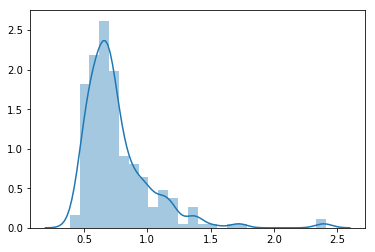

In [371]:
plt.close()
sns.distplot(mi4d[:,90000])
plt.show()

In [386]:
sns.distplot?

In [382]:
mmod = GaussianMixture(n_components=2)

In [383]:
mmod_a = mmod.fit(mi4d[:,90000].reshape(-1,1))

In [387]:
labs = mmod_a.predict(mi4d[:,90000].reshape(-1,1))

In [390]:
lprob1 = mmod_a.predict_proba(mi4d[:,90000].reshape(-1,1))[:,0]
lprob2 = mmod_a.predict_proba(mi4d[:,90000].reshape(-1,1))[:,1]

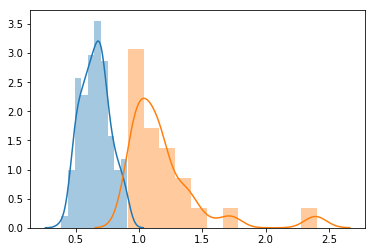

In [391]:
plt.close()
sns.distplot([mi4d[:,90000][x] for x in range(len(mi4d[:,90000])) if labs[x] == 0])
sns.distplot([mi4d[:,90000][x] for x in range(len(mi4d[:,90000])) if labs[x] == 1])
plt.show()

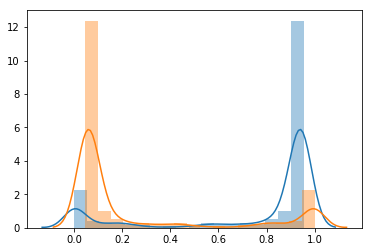

In [392]:
plt.close()
sns.distplot(lprob1)
sns.distplot(lprob2)
plt.show()